In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from influxdb_client import InfluxDBClient, Point, Dialect

import re

import time
import datetime

import warnings
from influxdb_client.client.warnings import MissingPivotFunction

import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
import matplotlib.colors as colors

# try:
#     # for Python2
#     from Tkinter import *   ## notice capitalized T in Tkinter 
# except ImportError:
#     # for Python3
#     from tkinter import *   ## notice lowercase 't' in tkinter here

pd.set_option('display.max_rows', 100)
import pandasql as ps
import sqlite3

In [2]:
#Read config file and load data into the variables

rx_dict = {
    'token': re.compile(r'var token = "(?P<token>.*)"\n'),
    'url': re.compile(r'var url = "(?P<url>.*)"\n'),
    'org': re.compile(r'var org = "(?P<org>.*)"\n'),
    'bucket': re.compile(r'var bucket = "(?P<bucket>.*)"\n'),
}

def _parse_line(line):
    """
    Do a regex search against all defined regexes and
    return the key and match result of the first matching regex

    """
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            return key, match
    # if there are no matches
    return None, None



filepath = '/root/flexi-pipe/config.go'
# open the file and read through it line by line
with open(filepath, 'r') as file_object:
    line = file_object.readline()
    while line:
        # at each line check for a match with a regex
        key, match = _parse_line(line)

        if key == 'token':
            token = match.group('token')
        elif key == 'url':
            url = match.group('url')
        elif key == 'org':
            org = match.group('org')
        elif key == 'bucket':
            bucket = match.group('bucket')
        
        line = file_object.readline()


url="http://192.168.20.58:8086"

In [3]:
client = InfluxDBClient(url=url, token=token, org=org,  timeout=30_000)

# write_api = client.write_api(write_options=SYNCHRONOUS)
query_api = client.query_api()

In [10]:
# Retrieve experiments data from csv
data = pd.read_csv('./experiments.csv', header=None)
df = pd.DataFrame(data)

#Rename columns
experiments = df.rename(columns={0: "start", 1: "end", 2: "topology", 3: "runtime", 4: "d", 5: "dlo", 6: "dhi", 7: "dscore", 8: "dlazy", 9: "dout", 10: "gossipFactor", 11: "initialDelay", 12: "interval"}, errors='raise')

#Correct timestamp
experiments["start"] = experiments["start"].str.slice(0, 27)
experiments["end"] = experiments["end"].str.slice(0, 27)

#String to timestamp
experiments['startUnix'] = pd.to_datetime(experiments["start"],format="%Y-%m-%d %H:%M:%S.%f").astype('int64') / 10**9
experiments['endUnix'] = pd.to_datetime(experiments["end"],format="%Y-%m-%d %H:%M:%S.%f").astype('int64') / 10**9

experiments['startUnix'] = pd.to_timedelta(experiments['startUnix'], unit='s').dt.total_seconds().astype(int)#.astype(str)
experiments['endUnix'] = pd.to_timedelta(experiments['endUnix'], unit='s').dt.total_seconds().astype(int)#.astype(str)

#Drop fields we don't mneed for the moment
exp = experiments.drop(columns=["runtime", "initialDelay"]).sort_values(by=["start"])

exp.head(100)

,start,end,topology,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,startUnix,endUnix
0,2023-08-01 18:12:39.9235463,2023-08-01 18:27:39.9823849,validator,8,6,12,4,8,2,0.25,0.5,1690913559,1690914459
1,2023-08-01 18:31:11.7897611,2023-08-01 18:46:11.8497848,validator,8,6,12,4,8,2,0.25,1.0,1690914671,1690915571
4,2023-08-01 19:26:50.4773509,2023-08-01 19:41:50.4791575,validator,12,6,12,4,8,2,0.25,1.0,1690918010,1690918910
2,2023-08-01 20:03:55.9990248,2023-08-01 20:18:56.0023639,validator,8,3,12,4,8,2,0.25,1.0,1690920235,1690921136
3,2023-08-01 20:22:28.8777816,2023-08-01 20:37:28.8852009,validator,8,6,12,6,8,2,0.25,1.0,1690921348,1690922248
5,2023-08-02 10:56:20.4955665,2023-08-02 11:11:20.4982340,general,8,6,12,4,8,2,0.25,0.5,1690973780,1690974680
6,2023-08-02 11:14:47.7918974,2023-08-02 11:29:47.8618204,general,8,6,12,4,8,2,0.25,1.0,1690974887,1690975787
7,2023-08-02 12:54:05.2745963,2023-08-02 13:09:05.2774139,unl,8,6,12,4,8,2,0.25,0.5,1690980845,1690981745
8,2023-08-02 13:12:29.3626010,2023-08-02 13:27:29.4399914,unl,8,6,12,4,8,2,0.25,1.0,1690981949,1690982849
9,2023-08-02 13:49:24.3574194,2023-08-02 14:04:24.3707622,unl,8,6,12,4,8,2,0.25,3.0,1690984164,1690985064


In [8]:
#Get times for different intervals
# intervals = exp["interval"].drop_duplicates().sort_values().reset_index(drop=True)
# intervals.head(10)

expTime = exp[exp['startUnix'].astype(int).between(1691157688,1691159701)]
expTime['experiment'] = expTime.index

expTime.head(20)

/tmp/ipykernel_6322/2369729725.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expTime['experiment'] = expTime.index


,start,end,topology,d,dlo,dhi,dscore,dlazy,dout,gossipFactor,interval,startUnix,endUnix,experiment
15,2023-08-04 14:01:28.8819245,2023-08-04 14:16:28.8861104,unl,6,6,12,4,8,2,0.25,1.0,1691157688,1691158588,15
16,2023-08-04 14:20:01.5015912,2023-08-04 14:35:01.6058005,unl,8,3,12,4,8,2,0.25,1.0,1691158801,1691159701,16


In [9]:
data_frame = query_api.query_data_frame('from(bucket: "gs") '
                                        ' |> range(start: 1691157688, stop:1691158588) '
                                        ' |> filter(fn: (r) => r._measurement == "message") '
                                        ' |> group(columns: ["_measurement", "_field"], mode: "by") '
                                        ' |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")')
client.close()

print(data_frame)

Empty DataFrame
Columns: []
Index: []


In [28]:

df = data_frame[["_time", "type"]]
# df = df.sort_values(by=["_time"]).reset_index(drop=True)
# df["_time"] = pd.to_datetime(df["_time"])

df.head(10)


,_time,type
0,2023-08-02 13:03:25.523263+00:00,9.0
1,2023-08-02 13:03:25.523337+00:00,9.0
2,2023-08-02 13:03:25.523379+00:00,9.0
3,2023-08-02 13:03:25.523419+00:00,9.0
4,2023-08-02 13:03:25.523468+00:00,9.0
5,2023-08-02 13:03:25.523518+00:00,9.0
6,2023-08-02 13:03:25.532288+00:00,4.0
7,2023-08-02 13:03:25.533731+00:00,4.0
8,2023-08-02 13:03:25.533846+00:00,6.0
9,2023-08-02 13:03:25.533919+00:00,4.0


In [33]:
#Make the db in memory
conn = sqlite3.connect(':memory:')
#write the tables
df.to_sql('df', conn, index=False)
expTime.to_sql('expTime', conn, index=False)

qry = '''
    select  
        df._time,
        df.type,
        expTime.experiment,
        expTime.interval
    from
        df join expTime on
        df._time between expTime.start and expTime.end
    '''
dfNew = pd.read_sql_query(qry, conn)

dfNew = dfNew.set_index('experiment').rename(columns={"_time": "min"})#.drop(columns=["messageID"])

dfNew['min'] = pd.to_datetime(dfNew["min"], format='mixed')
# dfNew['_min'] = pd.to_datetime(dfNew["_min"])

dfNew.head(20)

,min,type,interval
experiment,,,
7,2023-08-02 13:03:25.523263+00:00,9.0,0.5
7,2023-08-02 13:03:25.523337+00:00,9.0,0.5
7,2023-08-02 13:03:25.523379+00:00,9.0,0.5
7,2023-08-02 13:03:25.523419+00:00,9.0,0.5
7,2023-08-02 13:03:25.523468+00:00,9.0,0.5
7,2023-08-02 13:03:25.523518+00:00,9.0,0.5
7,2023-08-02 13:03:25.532288+00:00,4.0,0.5
7,2023-08-02 13:03:25.533731+00:00,4.0,0.5
7,2023-08-02 13:03:25.533846+00:00,6.0,0.5


In [37]:
#Try resampling for every 5 seconds
dfNoIndex = dfNew.reset_index()
# dfNoIndex.head(10)

by_time = dfNoIndex.groupby([dfNoIndex['experiment'],dfNoIndex['interval'],pd.Grouper(key="min", freq='10s')])['type'].count().reset_index()
dfAggTime = by_time.rename(columns={"type": "count"})


dfAggTime.head(100)

,experiment,interval,min,count
0,7,0.5,2023-08-02 12:59:50+00:00,32
1,7,0.5,2023-08-02 13:03:20+00:00,3117
2,7,0.5,2023-08-02 13:03:40+00:00,24451
3,7,0.5,2023-08-02 13:03:50+00:00,24737
4,7,0.5,2023-08-02 13:04:00+00:00,31013
5,7,0.5,2023-08-02 13:04:10+00:00,26291
6,7,0.5,2023-08-02 13:04:20+00:00,24827
7,7,0.5,2023-08-02 13:04:30+00:00,24998
8,7,0.5,2023-08-02 13:04:40+00:00,32016
9,7,0.5,2023-08-02 13:04:50+00:00,25036


In [38]:
#Min datetime of each experiment
minTime = dfAggTime.groupby(['experiment']).agg('min').drop(columns=['interval', 'count'])

# minTime.head(20)

#Join to calculate delta
dfWithMin = dfAggTime.merge(minTime, on='experiment', how='left').rename(columns={'min_x': '_time', 'min_y': '_min'})

dfWithMin['_time'] = pd.to_datetime(dfWithMin["_time"], format='mixed')
dfWithMin['_min'] = pd.to_datetime(dfWithMin["_min"],  format='mixed')

# #Calculate delta in seconds 
dfWithMin["delta"] = ((dfWithMin["_time"] - dfWithMin["_min"]) / pd.Timedelta(seconds=1)).astype(int)

# dfWithMin.head(100)

#Aggregate by time
gb = dfWithMin.groupby(['delta','experiment', 'interval'])['count'].agg(["sum"]).sort_values(by=["experiment", "delta"])
# gb.columns = gb.columns.droplevel(0)
# gb.reset_index(level=0, inplace=True)

# gb.head(100)

#Average by interval
intv = gb.groupby(['interval','delta']).agg(["mean"]).sort_values(by=["interval", "delta"])
intv.columns = intv.columns.droplevel(0)#.droplevel(1)
# intv.reset_index(level=0, inplace=True)
intv.reset_index(inplace=True)

intv.head(10)

,interval,delta,mean
0,0.5,0,32.0
1,0.5,210,3117.0
2,0.5,230,24451.0
3,0.5,240,24737.0
4,0.5,250,31013.0
5,0.5,260,26291.0
6,0.5,270,24827.0
7,0.5,280,24998.0
8,0.5,290,32016.0
9,0.5,300,25036.0


In [39]:
# get intervals
parameter ='interval'

intervals = intv[parameter].drop_duplicates().to_numpy()
# print(intervals)

for interval in np.nditer(intervals):
    print(interval)
    aux = intv.loc[intv["interval"] == interval]

aux.head(10)


0.5
1.0
3.0


,interval,delta,mean
106,3.0,0,7157.0
107,3.0,10,469.0
108,3.0,30,2313.0
109,3.0,50,2300.0
110,3.0,70,2278.0
111,3.0,90,2315.0
112,3.0,110,2290.0
113,3.0,130,2302.0
114,3.0,150,2363.0
115,3.0,170,2312.0


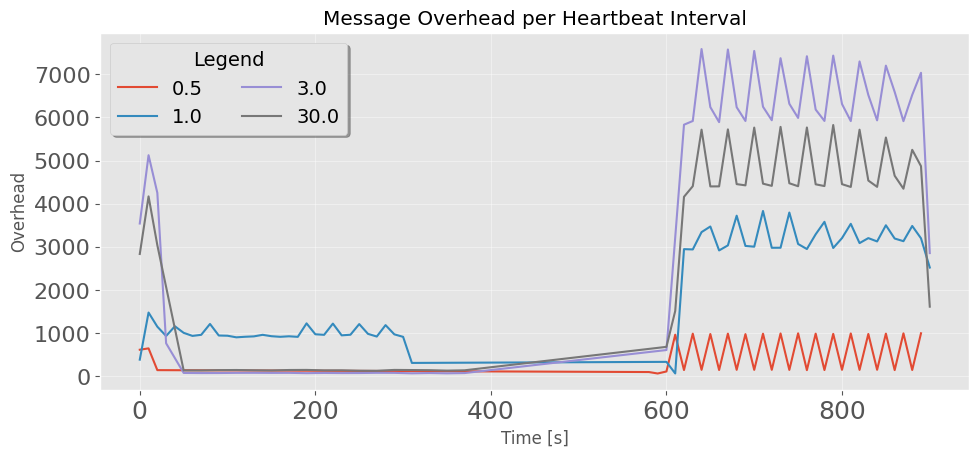

In [117]:
plt.style.use('ggplot')
# kwargs = dict(color=['hotpink'], alpha=0.9)#, density=True)

fig, ax = plt.subplots(constrained_layout=False)
ax.grid(alpha=0.4)

fig.tight_layout()
fig.subplots_adjust(left=0.19, bottom=0.09, right=0.98, top=0.92, wspace=0.17, hspace=0.17)

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

plt.gca().set(title='Message Overhead per Heartbeat Interval', ylabel='Overhead', xlabel="Time [s]")

plt.rcParams.update({'font.size': 14})
# plt.hist([x1, x2, x6], **kwargs, label=['GS 1 topic', 'Vanilla', 'Squelching'])
# plt.legend(loc='upper center', bbox_to_anchor=(0.58, 1))
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2))

plt.xticks(fontsize=18)
plt.yticks(fontsize=16)

fig.set_size_inches(11, 4.3)

for interval in np.nditer(intervals):
    aux = intv.loc[intv["interval"] == interval]
    interv = aux["interval"].drop_duplicates().item()
    plt.plot(aux["delta"], aux["mean"], label=interv)

ax.legend(loc="upper left", bbox_to_anchor=[0, 1],
                 ncols=2, shadow=True, title="Legend", fancybox=True)

fig.savefig('./figures/messOverheadInterval.pdf', format='pdf', facecolor='white', edgecolor='none', bbox_inches='tight', dpi=600)
fig.savefig('./figures/messOverheadInterval.png', format='png', facecolor='white', edgecolor='none', bbox_inches='tight', dpi=600)

plt.show()